# Manila: The New Normal 

## I. Introduction

The year is 2020, where COVID-19 has baffled each and everyone of us to survive, every place is subjected to quarantines and we are locked down in our own houses. The city of Manila is one of those areas that are subjected to be quarantined Enhanced Community Quarantine to be precise. After almost two months and a half, Manila is still in placed of quarantine but  now under General Community Quarantine starting June 1, 2020.  What is General Community Quarantine, what will be the impact of its implementation to establishments in each district and how can we react on this new guidelines.

**General Community Quarantine (GCQ)**  
  Category I Industries -  Power, energy, water and other utilities, agriculture, fishery and forestry industries, food manufacturing and food supply chain stores, and food preparation establishments insofar as take-out and delivery services, food delivery services, health-related establishments, the logistics sector, information technology and telecommunication companies, the media, at *full operational capacity*.

## II. Data Description

To solve the problem stated I used the following data:
  * **Official Gazette of the Philippines website** for the guideline of GCQ.
  * **Wikipedia** to get the  district names of manila and its postcodes.
  * **Foursquare** to get the most common venues nearby the given district.
  * **Google Maps**,*What's here* option to get the coordinates of each district.  

## III. Methodology

First we need to import and install all the libraries that will be needing to analyze the data.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0
print(plt.style.available)
mpl.style.use(['ggplot']) # optional: for ggplot-like style

print('Libraries imported.')

Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.

Matplotlib version:  3.1.3
['bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark-palette', 'seaborn-dark', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'seaborn', 'Solarize_Light2', 'tableau-colorblind10', '_classic_test']
Libraries imported.


As a database I did use my extracted data from wikipedia and placed it into a csv file together with the coordinates I got from Google Maps What's here option. Manila.csv file has Postal Code, District Name, City, and coordinates of each district.

In [2]:
df_manila = pd.read_csv('manila.csv')
df_manila.drop('Unnamed: 0', axis=1, inplace=True)
df_manila

,Postal Code,District Name,City,Latitude,Longitude
0,1001,Quiapo,Manila,14.598485,120.986142
1,1002,Intramuros,Manila,14.590882,120.974668
2,1003,Santa Cruz,Manila,14.618160,120.984746
3,1004,Malate,Manila,14.572039,120.992129
4,1005,San Miguel,Manila,14.595627,120.992666
5,1006,Binondo,Manila,14.601826,120.974956
6,1007,Paco,Manila,14.585956,120.993923
7,1008,Sampaloc,Manila,14.611135,120.996290
8,1009,Santa Ana,Manila,14.582749,121.013396
9,1010,San Nicolas,Manila,14.598296,120.968915


In [4]:
print('The dataframe has {} District and {} City.'.format(
        len(df_manila['District Name'].unique()),len(df_manila['City'].unique()),
        df_manila.shape[0]
    )
)

The dataframe has 16 District and 1 City.


In [5]:
address = 'Manila, Philippines'

geolocator = Nominatim(user_agent="ml_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manila are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manila are 14.5906216, 120.9799696.


First we need to visualize the location of districts in Manila so I used python *folium* library to visualize geographic details of Manila and its districts. I created a map of Manila with districts superimposed on top. I used the coordinates (latitude and longitude) values to get the visual as below:

In [158]:
neighborhoods = df_manila

# create map of manila using latitude and longitude values
map_manila = folium.Map(location=[latitude, longitude], zoom_start=13)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['District Name'], neighborhoods['City']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manila)  
    
map_manila

 Second, we need to look for the establishments near each district so I used Foursquare API to get the coordinates of nearby venues within each district. I selected the top 100 venues within 1km radius.

In [8]:
CLIENT_ID = 'EGKIABLZ1VNIV0CN3HCS2HHD34NZ15PQQNYBJBTEM5M5UTZ4' # your Foursquare ID
CLIENT_SECRET = '3WAU15IIPPKVOWJWFTUCVFNYUEGY11BXIFMA5UM00MX3IE0G' # your Foursquare Secret
VERSION = '20200531' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: EGKIABLZ1VNIV0CN3HCS2HHD34NZ15PQQNYBJBTEM5M5UTZ4
CLIENT_SECRET:3WAU15IIPPKVOWJWFTUCVFNYUEGY11BXIFMA5UM00MX3IE0G


In [11]:
df_manila.loc[0, 'City']
neighborhood_latitude = df_manila.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = df_manila.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = df_manila.loc[0, 'City'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Manila are 14.598485, 120.98614199999999.


In [12]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 1000 # define radius
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url 

'https://api.foursquare.com/v2/venues/explore?&client_id=EGKIABLZ1VNIV0CN3HCS2HHD34NZ15PQQNYBJBTEM5M5UTZ4&client_secret=3WAU15IIPPKVOWJWFTUCVFNYUEGY11BXIFMA5UM00MX3IE0G&v=20200531&ll=14.598485,120.98614199999999&radius=1000&limit=100'

In [13]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5ed3272ddd0f85001be02cae'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Quiapo',
  'headerFullLocation': 'Quiapo, Manila',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 98,
  'suggestedBounds': {'ne': {'lat': 14.607485009000008,
    'lng': 120.99542489547997},
   'sw': {'lat': 14.589484990999992, 'lng': 120.97685910452}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4e226448fa761d671086f507',
       'name': 'Krispy Kreme',
       'location': {'address': 'SM City Manila',
        'crossStreet': 'at Natividad Almeda-Lopez St & San Marcelino St',
        'lat': 14.601194803665472,
        'lng': 120.98277429240547,
       

In [14]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Here is a sample of venues that has been returned by Foursquare API.

In [15]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

C:\Users\popoy\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,Krispy Kreme,Donut Shop,14.601195,120.982774
1,98B,Public Art,14.598836,120.979435
2,BonChon Chicken,Fried Chicken Joint,14.601194,120.982791
3,The Den,Coffee Shop,14.598827,120.979450
4,Camera Alley (Hidalgo Street),Camera Store,14.598282,120.982625


In [16]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

98 venues were returned by Foursquare.


In [26]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [27]:
manila_venues = getNearbyVenues(names=df_manila['District Name'],
                                   latitudes=df_manila['Latitude'],
                                   longitudes=df_manila['Longitude']
                                  )

Quiapo
Intramuros
Santa Cruz
Malate
San Miguel
Binondo
Paco
Sampaloc
Santa Ana
San Nicolas
Pandacan
Tondo
Santa Mesa
San Andres Bukid
Port Area
Ermita


Foursquare returned **395** different venues within each district.

In [28]:
print(manila_venues.shape)
manila_venues

(395, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Quiapo,14.598485,120.986142,Krispy Kreme,14.601195,120.982774,Donut Shop
1,Quiapo,14.598485,120.986142,Camera Alley (Hidalgo Street),14.598282,120.982625,Camera Store
2,Quiapo,14.598485,120.986142,BonChon Chicken,14.601194,120.982791,Fried Chicken Joint
3,Quiapo,14.598485,120.986142,MaMonLuk,14.600309,120.984470,Noodle House
4,Quiapo,14.598485,120.986142,Globe Lumpia House,14.600626,120.984130,Vegetarian / Vegan Restaurant
5,Quiapo,14.598485,120.986142,Excelente Cooked Ham,14.597259,120.982632,Deli / Bodega
6,Quiapo,14.598485,120.986142,Simple Line,14.596231,120.988830,Tea Room
7,Quiapo,14.598485,120.986142,Yellow Cab Pizza Co.,14.602188,120.987288,Pizza Place
8,Quiapo,14.598485,120.986142,Wellmanson Beads & Accessories,14.597529,120.983196,Jewelry Store
9,Quiapo,14.598485,120.986142,Jollibee,14.602865,120.985575,Fast Food Restaurant


Summarize number of venues per district.

In [29]:
manila_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Binondo,100,100,100,100,100,100
Ermita,17,17,17,17,17,17
Intramuros,55,55,55,55,55,55
Malate,20,20,20,20,20,20
Paco,14,14,14,14,14,14
Pandacan,14,14,14,14,14,14
Port Area,4,4,4,4,4,4
Quiapo,61,61,61,61,61,61
Sampaloc,13,13,13,13,13,13


In [30]:
print('There are {} uniques categories.'.format(len(manila_venues['Venue Category'].unique())))

There are 91 uniques categories.


In [31]:
# one hot encoding
manila_onehot = pd.get_dummies(manila_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manila_onehot['Neighborhood'] = manila_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manila_onehot.columns[-1]] + list(manila_onehot.columns[:-1])
manila_onehot = manila_onehot[fixed_columns]

manila_onehot.head()

,Neighborhood,Antique Shop,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Basketball Court,Basketball Stadium,Beer Garden,Bistro,Boarding House,Bookstore,Bubble Tea Shop,Burger Joint,Café,Camera Store,Casino,Chinese Restaurant,Church,Clothing Store,Coffee Shop,Comedy Club,Comfort Food Restaurant,Convenience Store,Cosmetics Shop,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Electronics Store,Fast Food Restaurant,Filipino Restaurant,Flea Market,Flower Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Garden,Gift Shop,Golf Course,Government Building,Grocery Store,Gym,Gym / Fitness Center,Historic Site,History Museum,Hotel,Ice Cream Shop,Italian Restaurant,Japanese Restaurant,Jewelry Store,Korean Restaurant,Market,Mobile Phone Shop,Monument / Landmark,Multiplex,Museum,Nail Salon,Noodle House,Optical Shop,Pharmacy,Photography Lab,Pizza Place,Plaza,Pool,Pool Hall,Ramen Restaurant,Residential Building (Apartment / Condo),Restaurant,Roof Deck,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Shop & Service,Shopping Mall,Snack Place,Spa,Spanish Restaurant,Steakhouse,Supermarket,Tapas Restaurant,Tea Room,Train Station,Vegetarian / Vegan Restaurant,Veterinarian,Vietnamese Restaurant
0,Quiapo,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Quiapo,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Quiapo,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Quiapo,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Quiapo,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [32]:
manila_grouped = manila_onehot.groupby('Neighborhood').mean().reset_index()
manila_grouped

,Neighborhood,Antique Shop,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Basketball Court,Basketball Stadium,Beer Garden,Bistro,Boarding House,Bookstore,Bubble Tea Shop,Burger Joint,Café,Camera Store,Casino,Chinese Restaurant,Church,Clothing Store,Coffee Shop,Comedy Club,Comfort Food Restaurant,Convenience Store,Cosmetics Shop,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Electronics Store,Fast Food Restaurant,Filipino Restaurant,Flea Market,Flower Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Garden,Gift Shop,Golf Course,Government Building,Grocery Store,Gym,Gym / Fitness Center,Historic Site,History Museum,Hotel,Ice Cream Shop,Italian Restaurant,Japanese Restaurant,Jewelry Store,Korean Restaurant,Market,Mobile Phone Shop,Monument / Landmark,Multiplex,Museum,Nail Salon,Noodle House,Optical Shop,Pharmacy,Photography Lab,Pizza Place,Plaza,Pool,Pool Hall,Ramen Restaurant,Residential Building (Apartment / Condo),Restaurant,Roof Deck,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Shop & Service,Shopping Mall,Snack Place,Spa,Spanish Restaurant,Steakhouse,Supermarket,Tapas Restaurant,Tea Room,Train Station,Vegetarian / Vegan Restaurant,Veterinarian,Vietnamese Restaurant
0,Binondo,0.000000,0.000000,0.030000,0.000000,0.00000,0.060000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.030000,0.010000,0.050000,0.000000,0.00000,0.320000,0.010000,0.01000,0.020000,0.00,0.000000,0.010000,0.00000,0.020000,0.000000,0.00,0.02,0.000000,0.030000,0.01,0.000000,0.060000,0.000000,0.000000,0.00000,0.000000,0.000000,0.01,0.010000,0.000000,0.000000,0.000000,0.000000,0.010000,0.010000,0.000000,0.000000,0.000000,0.020000,0.010000,0.010000,0.03,0.000000,0.000000,0.010000,0.01,0.000000,0.01,0.000000,0.000000,0.020000,0.000000,0.000000,0.000000,0.050000,0.020000,0.000000,0.000000,0.01,0.000000,0.000000,0.000000,0.0000,0.000000,0.01,0.000000,0.020000,0.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.010000
1,Ermita,0.000000,0.000000,0.058824,0.000000,0.00000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.058824,0.000000,0.000000,0.000000,0.000000,0.00000,0.058824,0.000000,0.00000,0.058824,0.00,0.000000,0.058824,0.00000,0.000000,0.000000,0.00,0.00,0.000000,0.058824,0.00,0.000000,0.352941,0.000000,0.000000,0.00000,0.000000,0.000000,0.00,0.058824,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.058824,0.000000,0.058824,0.000000,0.00,0.000000,0.000000,0.000000,0.0000,0.058824,0.00,0.000000,0.000000,0.000000,0.000000,0.058824,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Intramuros,0.018182,0.000000,0.036364,0.018182,0.00000,0.000000,0.000000,0.000000,0.00,0.018182,0.000000,0.000000,0.000000,0.018182,0.000000,0.072727,0.000000,0.00000,0.000000,0.036364,0.00000,0.054545,0.00,0.018182,0.054545,0.00000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.127273,0.054545,0.000000,0.00000,0.000000,0.000000,0.00,0.018182,0.018182,0.018182,0.018182,0.018182,0.000000,0.018182,0.000000,0.054545,0.018182,0.036364,0.000000,0.036364,0.00,0.000000,0.000000,0.000000,0.00,0.018182,0.00,0.036364,0.000000,0.000000,0.000000,0.000000,0.000000,0.018182,0.036364,0.000000,0.018182,0.00,0.000000,0.054545,0.018182,0.0000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.018182,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Malate,0.000000,0.000000,0.000000,0.050000,0.00000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.050000,0.000000,0.00000,0.050000,0.000000,0.00000,0.150000,0.05,0.000000,0.100000,0.00000,0.000000,0.000000,0.05,0.00,0.000000,0.000000,0.00,0.000000,0.200000,0.050000,0.000000,0.00000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.0

In [33]:
num_top_venues = 5

for hood in manila_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = manila_grouped[manila_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Binondo----
                  venue  freq
0    Chinese Restaurant  0.32
1                Bakery  0.06
2  Fast Food Restaurant  0.06
3           Pizza Place  0.05
4                  Café  0.05


----Ermita----
                  venue  freq
0  Fast Food Restaurant  0.35
1     Convenience Store  0.06
2    Spanish Restaurant  0.06
3           Pizza Place  0.06
4            Donut Shop  0.06


----Intramuros----
                  venue  freq
0  Fast Food Restaurant  0.13
1                  Café  0.07
2     Convenience Store  0.05
3   Filipino Restaurant  0.05
4           Coffee Shop  0.05


----Malate----
                  venue  freq
0  Fast Food Restaurant  0.20
1           Coffee Shop  0.15
2                 Hotel  0.10
3     Convenience Store  0.10
4            Restaurant  0.10


----Paco----
                  venue  freq
0  Gym / Fitness Center  0.14
1         Grocery Store  0.14
2           Supermarket  0.07
3    Italian Restaurant  0.07
4                Market  0.07


----Pandacan

In [34]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [114]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = manila_grouped['Neighborhood']

for ind in np.arange(manila_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(manila_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Binondo,Chinese Restaurant,Fast Food Restaurant,Bakery,Pizza Place,Café,Bubble Tea Shop,Donut Shop,Asian Restaurant,Japanese Restaurant,Dim Sum Restaurant
1,Ermita,Fast Food Restaurant,Pizza Place,Sandwich Place,Donut Shop,Convenience Store,Coffee Shop,Chinese Restaurant,Pool,Bookstore,Fried Chicken Joint
2,Intramuros,Fast Food Restaurant,Café,Filipino Restaurant,Coffee Shop,Convenience Store,Historic Site,Restaurant,Asian Restaurant,Italian Restaurant,Plaza
3,Malate,Fast Food Restaurant,Coffee Shop,Restaurant,Hotel,Convenience Store,Comedy Club,BBQ Joint,Chinese Restaurant,Dessert Shop,Spa
4,Paco,Grocery Store,Gym / Fitness Center,Vietnamese Restaurant,Coffee Shop,Filipino Restaurant,Italian Restaurant,Diner,Market,Photography Lab,Bakery


### Viewing Venues Per District

In [36]:
manila_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Quiapo,14.598485,120.986142,Krispy Kreme,14.601195,120.982774,Donut Shop
1,Quiapo,14.598485,120.986142,Camera Alley (Hidalgo Street),14.598282,120.982625,Camera Store
2,Quiapo,14.598485,120.986142,BonChon Chicken,14.601194,120.982791,Fried Chicken Joint
3,Quiapo,14.598485,120.986142,MaMonLuk,14.600309,120.984470,Noodle House
4,Quiapo,14.598485,120.986142,Globe Lumpia House,14.600626,120.984130,Vegetarian / Vegan Restaurant


In [65]:
df_venues = manila_venues['Neighborhood'].value_counts()
df_venues = df_venues.reset_index()
df_venues.columns = ['District', 'Counts']
df_venues.set_index('District', inplace=True)
df_venues_sorted = df_venues.sort_values(by='Counts', ascending=True, inplace=True)
df_venues

,Counts
District,
Port Area,4
Santa Mesa,4
San Nicolas,5
San Andres Bukid,7
Tondo,11
Santa Ana,11
Sampaloc,13
Pandacan,14
Paco,14


Here is a horizontal bar graph to represent how many venues returned by each district.

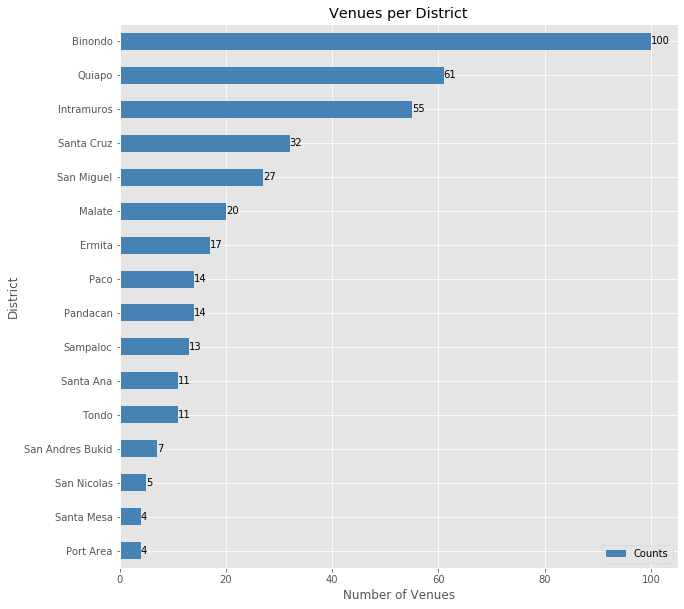

In [84]:
df_venues.plot(kind='barh', color = 'steelblue', figsize=(10, 10))


plt.xlabel('Number of Venues') # add to x-label to the plot
plt.ylabel('District') # add y-label to the plot
plt.title('Venues per District') # add title to the plot

for y, x in enumerate(df_venues['Counts']):
    plt.annotate(str(x), xy=(x, y), va='center', color='black')
    
plt.show()

### Clustering and Segmentation of  Districts of Manila

Third, we need to cluster the districts. As for clustering and segmentation of districts of Manila, I did use a machine learning technique called *K-means clustering*. An unsupervised machine learning technique used to divide data into non-overlapping subsets or clusters without any cluster internal structure.The data within the cluster are very similar and the data on each cluster are different from each other.

In [150]:
# set number of clusters
kclusters = 5

manila_grouped_clustering = manila_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manila_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 2, 0, 0, 0, 0, 4, 0, 0, 1])

In [151]:
# add clustering labels
#neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

manila_merged = df_manila

# merge manila_grouped with manila_data to add latitude/longitude for each neighborhood
manila_merged = manila_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='District Name')

manila_merged.head() # check the last columns!

,Postal Code,District Name,City,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1001,Quiapo,Manila,14.598485,120.986142,0,Fast Food Restaurant,Convenience Store,Chinese Restaurant,Pizza Place,Optical Shop,Camera Store,Electronics Store,Fried Chicken Joint,Donut Shop,Jewelry Store
1,1002,Intramuros,Manila,14.590882,120.974668,0,Fast Food Restaurant,Café,Filipino Restaurant,Coffee Shop,Convenience Store,Historic Site,Restaurant,Asian Restaurant,Italian Restaurant,Plaza
2,1003,Santa Cruz,Manila,14.618160,120.984746,0,Coffee Shop,BBQ Joint,Filipino Restaurant,Bakery,Pizza Place,Ice Cream Shop,Salon / Barbershop,Flower Shop,Café,Department Store
3,1004,Malate,Manila,14.572039,120.992129,0,Fast Food Restaurant,Coffee Shop,Restaurant,Hotel,Convenience Store,Comedy Club,BBQ Joint,Chinese Restaurant,Dessert Shop,Spa
4,1005,San Miguel,Manila,14.595627,120.992666,0,Convenience Store,Filipino Restaurant,Café,Tea Room,Fast Food Restaurant,Burger Joint,Bubble Tea Shop,Residential Building (Apartment / Condo),Boarding House,History Museum


I created a map that shows each cluster per color.

In [152]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manila_merged['Latitude'], manila_merged['Longitude'], manila_merged['District Name'], manila_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## IV. Results

### Cluster 1 - Food  District
Based on the most common venues in each district this cluster is made mostly of fastfood restaurants and coffee shops.

In [153]:
manila_merged.loc[manila_merged['Cluster Labels'] == 0, manila_merged.columns[[1] + list(range(5, manila_merged.shape[1]))]]

,District Name,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Quiapo,0,Fast Food Restaurant,Convenience Store,Chinese Restaurant,Pizza Place,Optical Shop,Camera Store,Electronics Store,Fried Chicken Joint,Donut Shop,Jewelry Store
1,Intramuros,0,Fast Food Restaurant,Café,Filipino Restaurant,Coffee Shop,Convenience Store,Historic Site,Restaurant,Asian Restaurant,Italian Restaurant,Plaza
2,Santa Cruz,0,Coffee Shop,BBQ Joint,Filipino Restaurant,Bakery,Pizza Place,Ice Cream Shop,Salon / Barbershop,Flower Shop,Café,Department Store
3,Malate,0,Fast Food Restaurant,Coffee Shop,Restaurant,Hotel,Convenience Store,Comedy Club,BBQ Joint,Chinese Restaurant,Dessert Shop,Spa
4,San Miguel,0,Convenience Store,Filipino Restaurant,Café,Tea Room,Fast Food Restaurant,Burger Joint,Bubble Tea Shop,Residential Building (Apartment / Condo),Boarding House,History Museum
5,Binondo,0,Chinese Restaurant,Fast Food Restaurant,Bakery,Pizza Place,Café,Bubble Tea Shop,Donut Shop,Asian Restaurant,Japanese Restaurant,Dim Sum Restaurant
6,Paco,0,Grocery Store,Gym / Fitness Center,Vietnamese Restaurant,Coffee Shop,Filipino Restaurant,Italian Restaurant,Diner,Market,Photography Lab,Bakery
7,Sampaloc,0,Filipino Restaurant,Pizza Place,Bar,Diner,Burger Joint,Fast Food Restaurant,Flea Market,Bistro,Nail Salon,Arts & Crafts Store
10,Pandacan,0,Grocery Store,Pharmacy,Nail Salon,BBQ Joint,Supermarket,Convenience Store,Plaza,Filipino Restaurant,Snack Place,Fast Food Restaurant
11,Tondo,0,Food Truck,Fast Food Restaurant,Convenience Store,Gym,Filipino Restaurant,Snack Place,Café,Diner,Korean Restaurant,Donut Shop


### Cluster 2 - General Purpose District
Based on the most common venues in each district this cluster is mostly composed of general purpose entities like grocery, convenience and department stores.

In [154]:
manila_merged.loc[manila_merged['Cluster Labels'] == 1, manila_merged.columns[[1] + list(range(5, manila_merged.shape[1]))]]

,District Name,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,San Nicolas,1,Convenience Store,Plaza,Grocery Store,Historic Site,Chinese Restaurant,Dumpling Restaurant,Cosmetics Shop,Deli / Bodega,Department Store,Dessert Shop
13,San Andres Bukid,1,Grocery Store,Train Station,BBQ Joint,Bakery,Chinese Restaurant,Convenience Store,Burger Joint,Vietnamese Restaurant,Dumpling Restaurant,Deli / Bodega


#### Cluster 3 - Mixed District
Based on the most common venues in this cluster, this districts have venues that are mixed with recreation and food venues.

In [155]:
manila_merged.loc[manila_merged['Cluster Labels'] == 2, manila_merged.columns[[1] + list(range(5, manila_merged.shape[1]))]]

,District Name,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Santa Ana,2,Fast Food Restaurant,Shop & Service,Convenience Store,Asian Restaurant,Tea Room,Basketball Court,Flea Market,Dumpling Restaurant,Cosmetics Shop,Deli / Bodega
15,Ermita,2,Fast Food Restaurant,Pizza Place,Sandwich Place,Donut Shop,Convenience Store,Coffee Shop,Chinese Restaurant,Pool,Bookstore,Fried Chicken Joint


### Cluster 4 -  Emerging District
Based on the most common venues this district is where medicine is most accesible. It also does have venues for arts and craft, mixed with resturants and convenience stores.

In [156]:
manila_merged.loc[manila_merged['Cluster Labels'] == 3, manila_merged.columns[[1] + list(range(5, manila_merged.shape[1]))]]

,District Name,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,Santa Mesa,3,Pharmacy,Arts & Crafts Store,Convenience Store,Filipino Restaurant,Dumpling Restaurant,Cosmetics Shop,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant


### Cluster 5 - Self-Conscious District
Based on the most common venues in this cluster, most of the venues are for maintaining and making the body beautiful and healthy.

In [157]:
manila_merged.loc[manila_merged['Cluster Labels'] == 4, manila_merged.columns[[1] + list(range(5, manila_merged.shape[1]))]]

,District Name,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,Port Area,4,Cosmetics Shop,Gym,Basketball Stadium,Fast Food Restaurant,Vietnamese Restaurant,Electronics Store,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant


## V. Discussion

Based on the data above we may conclude:

1. Cluster 1: Food District
  * Observation: The most affected cluster because it is mainly composed of food establishments and cafe shops.Access to food is convinient to people living in this clusters because it has a lot to offer.
  * Recommendation: Food Establishments in this cluster may survived if they do offer take out and online delivery services. 
  
2. Cluster 2: General Purpose District
  * Observation: Establishments in this cluster are may thrive in this period because they offer basic necessities needed by people for their day to day activities. There were also a lot of food establishments in this cluster which may be affected by the ongoing pandemic.Access to basic neccesities is convinient to people living in this cluster.
  * Recommendation: Food Establishments in this cluster may survived if they do offer take out and online delivery services.
  
3. Cluster 3: Mixed District
  * Observation: Recreation establishment are probihited on this cluster based on the GCQ guidelines.  Food establishment are not that many in this cluster but there is a flea market wherein people may access cheap valuable foods.
  * Recommendation: Unusable recreation establishment like basketball courts may be used as quarantine area for people that has been suspected with COVID. Food Establishments in this cluster may survived if they do offer take out and online delivery services.
 
4. Cluster 4: Emerging District
 * Observation:  Pharmacy is the most common venue in these cluster, people living in this area are in luck because they do have convinience in buying medicine. Also there is a department store in this cluster where people can get what they need. 
 * Recommendation:  Establishments in this cluster may surived if the do offer online delivery services. I also do observed that there is a lot less restaurants and cafes in this area so when this pandemic is over this cluster can be is a good place to start restaurant and cafes.
 
5. Cluster 5: Self-Conscious District
 * Observation: Most of the common venues in this cluster are probihited by the GCQ guidelines, so this cluster is also greatly affected by the pandemic. 
 * Recommendation: Unusable recreation establishment like basketball courts may be used as quarantine area for people that has been suspected with COVID.I also do observed that there is a lot less restaurants and cafes in this area so when this pandemic is over this cluster can be is a good place to start restaurant and cafes.

## VI. Conclusion

We may conclude that the information on clustering districts in Manila that there are districts that are congested with establishments especially on those food service industry that are greatly affected by this pandemic. Unless those establishments cope up with the technology so they can have the means to survive in these difficult times. The information may also help the government on where to focus and what kind of establishments needed assistance.  

If we look at the brighter side, clustering the districts also revealed the information that there are districts that are less lot to offer which can be a good sign for the investors to start a new kind of business wherein they may thrive and succed. Maybe in the future their business may be considered as most common venue.

We are all in this together. This too shall pass.  

Ervin Vinzon

## VII. References

  * https://en.wikipedia.org/wiki/Manila#Barangays_and_districts  
  * https://developer.foursquare.com  
  * https://www.officialgazette.gov.ph/downloads/2020/05may/20200522-omnibus-guidelines-on-the-implementation-of-community-quarantine-in-the-philippines.pdf  
  * https://www.google.com/maps